In [2]:
import spacy
import random
from collections import Counter #for counting
import seaborn as sns #for visualization
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
nlp = spacy.load('en_core_web_sm')
reddit = pd.read_csv("../test_data.csv")

## About spaCy

spaCy is a free open-source library for Natural Language Processing in Python. 

It features NER, POS tagging, dependency parsing, word vectors and more. The name spaCy comes from spaces + Cython. This is because spaCy started off as an industrial grade solution for tokenization - and eventually expanding to other challenges. Cython allows spaCy to be incredibly fast as compared to other solutions like NLTK. 

It has trainable, or in other words customizable and extendable models for most of these tasks - while providing some really good models out of the box. 

# Named Entity Recognition aka NER

> spaCy can recognise various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn't always work perfectly and might need some tuning later, depending on your use case.
> 
>  -- from the amazing [spaCy docs](https://spacy.io/usage/linguistic-features#section-named-entities)

## Entities Explained

| Type | 	Description|
|:---|:---
| PERSON |	People, including fictional. |
| NORP | Nationalities or religious or political groups.| 
| FAC|  	Buildings, airports, highways, bridges, etc.| 
| ORG|  	Companies, agencies, institutions, etc.| 
| GPE|  	Countries, cities, states.| 
| LOC|  	Non-GPE locations, mountain ranges, bodies of water.| 
| PRODUCT|  	Objects, vehicles, foods, etc. (Not services.)| 
| EVENT|  	Named hurricanes, battles, wars, sports events, etc.| 
| WORK_OF_ART|  	Titles of books, songs, etc.| 
| LAW|  	Named documents made into laws.| |
| LANGUAGE|  	Any named language.| 
| DATE|  	Absolute or relative dates or periods.| 
| TIME|  	Times smaller than a day.| 
| PERCENT|  	Percentage, including "%".| 
| MONEY|  	Monetary values, including unit.| 
| QUANTITY|  	Measurements, as of weight or distance.| 
| ORDINAL|  	"first", "second", etc.| 
| CARDINAL|  	Numerals that do not fall under another type.| 

In [4]:
def explain_text_entities(text):
    doc = nlp(text)
    for ent in doc.ents:
        print(f'Entity: {ent}, Label: {ent.label_}, {spacy.explain(ent.label_)}')

explain_text_entities(reddit['title'][222])

Entity: Boys Ass Toys, Label: PERSON, People, including fictional
Entity: @foone, Label: ORG, Companies, agencies, institutions, etc.


In [5]:
one_sentence = reddit["title"][111]
doc = nlp(one_sentence)
spacy.displacy.render(doc, style='ent',jupyter=True)

# What topics are discussed on reddit?

One way to explore this would be to mine out all the noun chunk. The doc object has a attribute [noun chunk](https://spacy.io/api/doc)

> **Note:** * spaCy enforces a max limit of 1000000 characters for NER and similar use cases. *



In [6]:
text = reddit['title'].str.cat(sep=' ')

# removing URLs and '&amp' substrings using regex
import re
url_reg  = r'[a-z]*[:.]+\S+'
text   = re.sub(url_reg, '', text)
noise_reg = r'\&amp'
text   = re.sub(noise_reg, '', text)

doc = nlp(text)

# Use Doc attribute noun_chunk
item = list(doc.noun_chunks)

# each element in this list is spaCy's inbuilt `Span`, which is not useful for us SO convert to a string
items = [str(x) for x in item ]

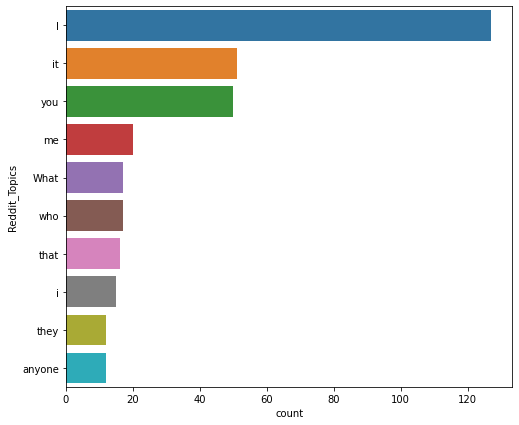

In [7]:
df_nouns = pd.DataFrame(items, columns=["Reddit_Topics"])
plt.figure(figsize=(8,7))
sns.countplot(y="Reddit_Topics",
             data=df_nouns,
             order=df_nouns["Reddit_Topics"].value_counts().iloc[:10].index)
plt.show()

As expected mainly filler words or pronouns. Need to remove them!  

In [8]:
reddit_topics = []
for token in doc:
    if (not token.is_stop) and (token.pos_ == "NOUN") and (len(str(token))>2):
        reddit_topics.append(token)
        
reddit_topics = [str(x) for x in reddit_topics]

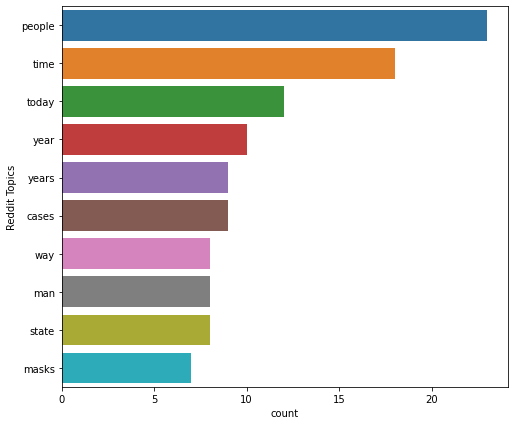

In [9]:
df_nouns = pd.DataFrame(reddit_topics, columns=["Reddit Topics"])
df_nouns
plt.figure(figsize=(8,7))
sns.countplot(y="Reddit Topics",
             data=df_nouns,
             order=df_nouns["Reddit Topics"].value_counts().iloc[:10].index)
plt.show()

Once we remove the filler word we get... something pretty boring. 

# Exploring Ent...ities

![](https://www.google.com/url?sa=i&url=https%3A%2F%2Flotr.fandom.com%2Fwiki%2FTreebeard&psig=AOvVaw1qAoLsQErfEeaqMvxfH086&ust=1595351690658000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCPDugqqq3OoCFQAAAAAdAAAAABAD)


In [10]:
reddit_ents = []
for ent in doc.ents:
    if ent.label_ not in ["PERCENT", "CARDINAL", "DATE"]:
        reddit_ents.append(ent.text.strip())

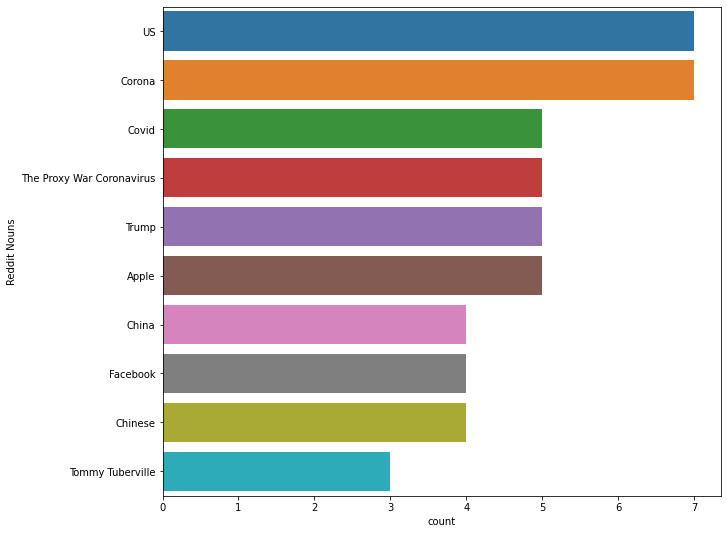

In [13]:
df_ttopics = pd.DataFrame(reddit_ents, columns=["Reddit Nouns"])
plt.figure(figsize=(10,9))
sns.countplot(y="Reddit Nouns",
             data=df_ttopics,
             order=df_ttopics["Reddit Nouns"].value_counts().iloc[1:11].index)
plt.show()

Better! We can see that, in the top 10, the most popular topics are Corona and Covid. 

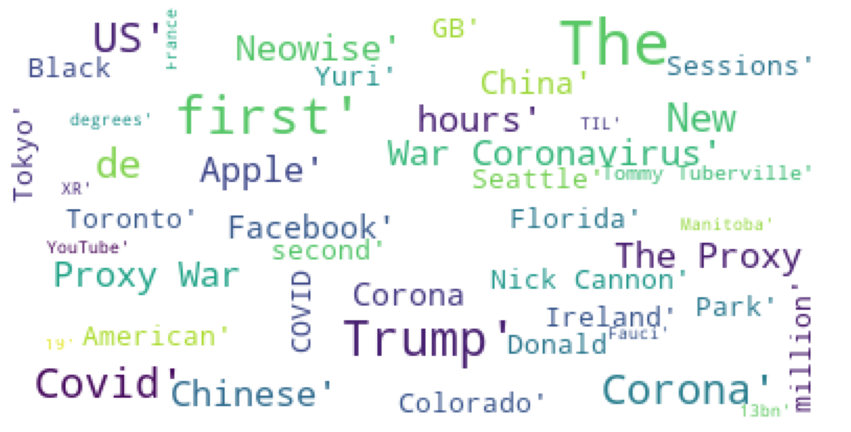

In [14]:
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
plt.figure(figsize=(15,10))
wordcloud = WordCloud(background_color="white",
                      stopwords = STOP_WORDS,
                      max_words=45,
                      max_font_size=30,
                      random_state=42
                     ).generate(str(reddit_ents))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()